In [9]:
import cv2
import numpy as np
import csv
import os
import glob

# === KONFIGURACJA ===
# seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
seq_file_name= '600_51n12_1_2mm_-161_09_02_18_483'
frames_dir = f'frames_output/{seq_file_name}/preview_fixed'
mask_path = 'images/maska.png'
output_csv = f'anomaly_metrics_{seq_file_name}.csv'
output_img_dir = f"results/{seq_file_name}"

# === Wczytaj maskę spoiny ===
spoiny_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if spoiny_mask is None:
    raise ValueError("Nie można wczytać maski spoiny!")

# === Lista klatek ===
frame_files = sorted(glob.glob(os.path.join(frames_dir, 'frame_*.jpg')))
print(f"Znaleziono {len(frame_files)} klatek do przetworzenia.")

# === Przygotowanie folderu na obrazy wynikowe ===
os.makedirs(output_img_dir, exist_ok=True)

# === Przygotowanie pliku CSV ===
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["frame", "num_anomalies", "anomaly_ratio_percent", "mean_temp", "std_temp", "min_temp", "max_temp"])

    # === Pętla po klatkach ===
    for frame_path in frame_files:
        frame_name = os.path.basename(frame_path)

        thermal_img = cv2.imread(frame_path, cv2.IMREAD_UNCHANGED)
        if thermal_img is None:
            print(f"❌ Nie można wczytać: {frame_name}")
            continue

        if len(thermal_img.shape) == 3:
            thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)

        thermal_img = thermal_img.astype(np.float32)

        # Dopasowanie maski
        if spoiny_mask.shape != thermal_img.shape:
            spoiny_mask_resized = cv2.resize(spoiny_mask, (thermal_img.shape[1], thermal_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        else:
            spoiny_mask_resized = spoiny_mask.copy()

        _, spoiny_mask_bin = cv2.threshold(spoiny_mask_resized, 127, 1, cv2.THRESH_BINARY)

        spoiny_temps = thermal_img[spoiny_mask_bin == 1]
        if len(spoiny_temps) == 0:
            print(f"⚠️ Pusta maska w {frame_name}")
            continue

        # Statystyki
        mean_temp = np.mean(spoiny_temps)
        std_temp = np.std(spoiny_temps)
        min_temp = np.min(spoiny_temps)
        max_temp = np.max(spoiny_temps)

        # Detekcja anomalii
        anomaly_mask = np.zeros_like(spoiny_mask_resized, dtype=np.uint8)
        anomaly_pixels = (thermal_img > mean_temp + 2 * std_temp) | (thermal_img < mean_temp - 2 * std_temp)
        anomaly_mask[(spoiny_mask_bin == 1) & anomaly_pixels] = 255

        contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_anomalies = len(contours)
        anomaly_ratio = (np.sum(anomaly_mask == 255) / np.sum(spoiny_mask_bin == 1)) * 100

        # === Zapis obrazu z konturami i centroidami (jeśli są) ===
        if num_anomalies > 0:
            annotated = cv2.cvtColor(thermal_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
            cv2.drawContours(annotated, contours, -1, (0, 0, 255), 1)

            for cnt in contours:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    cv2.circle(annotated, (cx, cy), 3, (255, 0, 0), -1)

            output_path = os.path.join(output_img_dir, f"anomaly_{frame_name}")
            cv2.imwrite(output_path, annotated)

        # === Zapis do CSV ===
        writer.writerow([
            frame_name,
            num_anomalies,
            f"{anomaly_ratio:.2f}",
            f"{mean_temp:.2f}",
            f"{std_temp:.2f}",
            f"{min_temp:.2f}",
            f"{max_temp:.2f}"
        ])

        print(f"✅ {frame_name}: {num_anomalies} anomalii, {anomaly_ratio:.2f}%")

print(f"\n🎯 Zakończono. Dane zapisane do: {output_csv}")


Znaleziono 2401 klatek do przetworzenia.
✅ frame_000000.jpg: 457 anomalii, 3.73%
✅ frame_000001.jpg: 468 anomalii, 3.90%
✅ frame_000002.jpg: 447 anomalii, 3.68%
✅ frame_000003.jpg: 464 anomalii, 3.90%
✅ frame_000004.jpg: 469 anomalii, 3.90%
✅ frame_000005.jpg: 470 anomalii, 3.85%
✅ frame_000006.jpg: 437 anomalii, 3.65%
✅ frame_000007.jpg: 491 anomalii, 3.92%
✅ frame_000008.jpg: 502 anomalii, 4.13%
✅ frame_000009.jpg: 419 anomalii, 3.48%
✅ frame_000010.jpg: 483 anomalii, 4.01%
✅ frame_000011.jpg: 490 anomalii, 4.24%
✅ frame_000012.jpg: 482 anomalii, 4.10%
✅ frame_000013.jpg: 470 anomalii, 4.02%
✅ frame_000014.jpg: 477 anomalii, 3.81%
✅ frame_000015.jpg: 445 anomalii, 3.85%
✅ frame_000016.jpg: 490 anomalii, 4.06%
✅ frame_000017.jpg: 518 anomalii, 4.41%
✅ frame_000018.jpg: 448 anomalii, 3.74%
✅ frame_000019.jpg: 481 anomalii, 3.87%
✅ frame_000020.jpg: 487 anomalii, 3.89%
✅ frame_000021.jpg: 435 anomalii, 3.51%
✅ frame_000022.jpg: 480 anomalii, 4.00%
✅ frame_000023.jpg: 487 anomalii, 4.13%

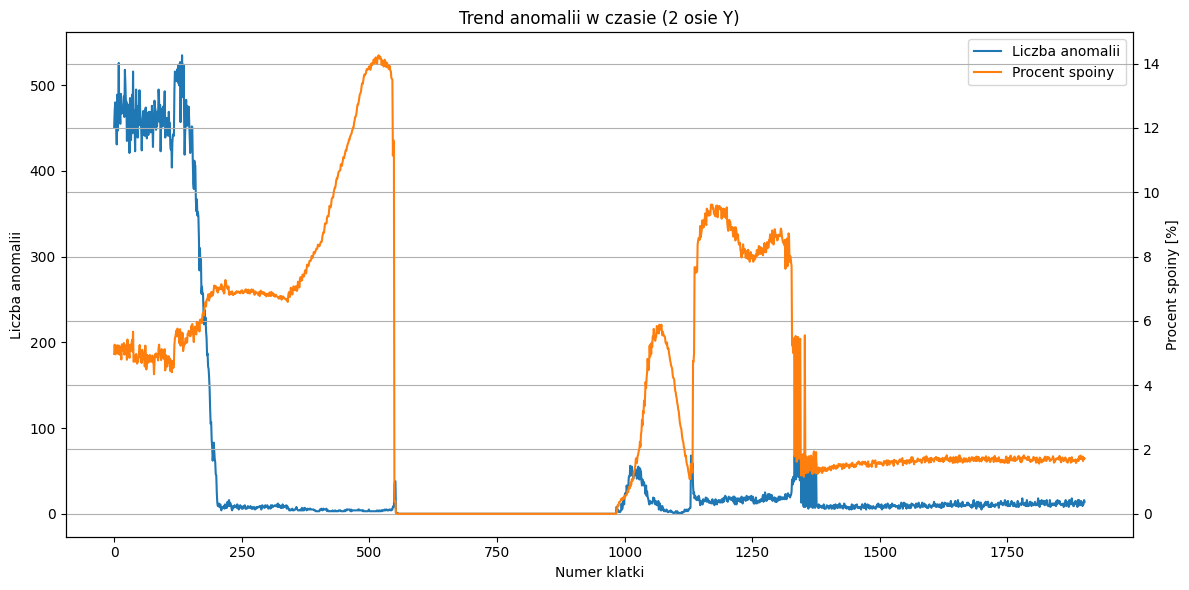

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# === Wczytaj CSV ===
# csv_path = 'anomaly_metrics_625_38n18_1_2mm_-161_07_41_19_806.csv'
csv_path = f'anomaly_metrics_{seq_file_name}.csv'
df = pd.read_csv(csv_path)

# === Wyciągnij numer klatki z nazw plików (np. 001300)
df['frame_num'] = df['frame'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

# === Sortuj po numerze klatki
df = df.sort_values('frame_num')

# === Wykres trendu
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Numer klatki")
ax1.set_ylabel("Liczba anomalii")
ax1.plot(df['frame_num'], df['num_anomalies'], color='tab:blue', label="Liczba anomalii")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel("Procent spoiny [%]")
ax2.plot(df['frame_num'], df['anomaly_ratio_percent'], color='tab:orange', label="Procent spoiny")
ax2.tick_params(axis='y')

# === Dodanie legendy
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title("Trend anomalii w czasie (2 osie Y)")
plt.grid(True)
plt.tight_layout()
plt.show()




In [13]:
import cv2
import numpy as np
import csv
import os
import glob

# === KONFIGURACJA ===
# seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
frames_dir = f'frames_output/{seq_file_name}/preview_fixed'
mask_path = 'images/maska.png'
output_csv = f'anomaly_metrics_{seq_file_name}.csv'
output_img_dir = f"results/{seq_file_name}"

# === Wczytaj maskę spoiny ===
spoiny_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if spoiny_mask is None:
    raise ValueError("Nie można wczytać maski spoiny!")

# === Lista klatek ===
frame_files = sorted(glob.glob(os.path.join(frames_dir, 'frame_*.jpg')))
print(f"Znaleziono {len(frame_files)} klatek do przetworzenia.")

# === Przygotowanie folderu na obrazy wynikowe ===
os.makedirs(output_img_dir, exist_ok=True)

# === Przygotowanie pliku CSV ===
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "frame",
        "num_anomalies",
        "anomaly_ratio_percent",
        "mean_anomaly_area",
        "mean_temp",
        "std_temp",
        "min_temp",
        "max_temp"
    ])

    # === Pętla po klatkach ===
    for frame_path in frame_files:
        frame_name = os.path.basename(frame_path)

        thermal_img = cv2.imread(frame_path, cv2.IMREAD_UNCHANGED)
        if thermal_img is None:
            print(f"❌ Nie można wczytać: {frame_name}")
            continue

        if len(thermal_img.shape) == 3:
            thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)

        thermal_img = thermal_img.astype(np.float32)

        # Dopasowanie maski
        if spoiny_mask.shape != thermal_img.shape:
            spoiny_mask_resized = cv2.resize(spoiny_mask, (thermal_img.shape[1], thermal_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        else:
            spoiny_mask_resized = spoiny_mask.copy()

        _, spoiny_mask_bin = cv2.threshold(spoiny_mask_resized, 127, 1, cv2.THRESH_BINARY)

        spoiny_temps = thermal_img[spoiny_mask_bin == 1]
        if len(spoiny_temps) == 0:
            print(f"⚠️ Pusta maska w {frame_name}")
            continue

        # Statystyki temperatur
        mean_temp = np.mean(spoiny_temps)
        std_temp = np.std(spoiny_temps)
        min_temp = np.min(spoiny_temps)
        max_temp = np.max(spoiny_temps)

        # Detekcja anomalii
        anomaly_mask = np.zeros_like(spoiny_mask_resized, dtype=np.uint8)
        anomaly_pixels = (thermal_img > mean_temp + 2 * std_temp) | (thermal_img < mean_temp - 2 * std_temp)
        anomaly_mask[(spoiny_mask_bin == 1) & anomaly_pixels] = 255

        contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_anomalies = len(contours)
        anomaly_ratio = (np.sum(anomaly_mask == 255) / np.sum(spoiny_mask_bin == 1)) * 100

        # Oblicz średnią powierzchnię anomalii
        areas = [cv2.contourArea(cnt) for cnt in contours]
        total_area = np.sum(areas)
        mean_anomaly_area = total_area / num_anomalies if num_anomalies > 0 else 0.0

        # === Zapis obrazu z konturami i centroidami (jeśli są) ===
        if num_anomalies > 0:
            annotated = cv2.cvtColor(thermal_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
            cv2.drawContours(annotated, contours, -1, (0, 0, 255), 1)

            for cnt in contours:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    cv2.circle(annotated, (cx, cy), 3, (255, 0, 0), -1)

            output_path = os.path.join(output_img_dir, f"anomaly_{frame_name}")
            cv2.imwrite(output_path, annotated)

        # === Zapis danych do CSV ===
        writer.writerow([
            frame_name,
            num_anomalies,
            f"{anomaly_ratio:.2f}",
            f"{mean_anomaly_area:.2f}",
            f"{mean_temp:.2f}",
            f"{std_temp:.2f}",
            f"{min_temp:.2f}",
            f"{max_temp:.2f}"
        ])

        print(f"✅ {frame_name}: {num_anomalies} anomalii, {anomaly_ratio:.2f}%, średnia powierzchnia: {mean_anomaly_area:.2f}")


Znaleziono 1902 klatek do przetworzenia.
✅ frame_000000.jpg: 451 anomalii, 4.97%, średnia powierzchnia: 0.42
✅ frame_000001.jpg: 470 anomalii, 5.26%, średnia powierzchnia: 0.41
✅ frame_000002.jpg: 480 anomalii, 4.99%, średnia powierzchnia: 0.42
✅ frame_000003.jpg: 466 anomalii, 4.96%, średnia powierzchnia: 0.36
✅ frame_000004.jpg: 459 anomalii, 5.22%, średnia powierzchnia: 0.37
✅ frame_000005.jpg: 431 anomalii, 5.03%, średnia powierzchnia: 0.49
✅ frame_000006.jpg: 489 anomalii, 5.24%, średnia powierzchnia: 0.36
✅ frame_000007.jpg: 447 anomalii, 5.01%, średnia powierzchnia: 0.50
✅ frame_000008.jpg: 476 anomalii, 4.97%, średnia powierzchnia: 0.34
✅ frame_000009.jpg: 526 anomalii, 5.23%, średnia powierzchnia: 0.31
✅ frame_000010.jpg: 457 anomalii, 4.96%, średnia powierzchnia: 0.37
✅ frame_000011.jpg: 471 anomalii, 5.20%, średnia powierzchnia: 0.30
✅ frame_000012.jpg: 455 anomalii, 4.94%, średnia powierzchnia: 0.44
✅ frame_000013.jpg: 490 anomalii, 5.17%, średnia powierzchnia: 0.38
✅ frame

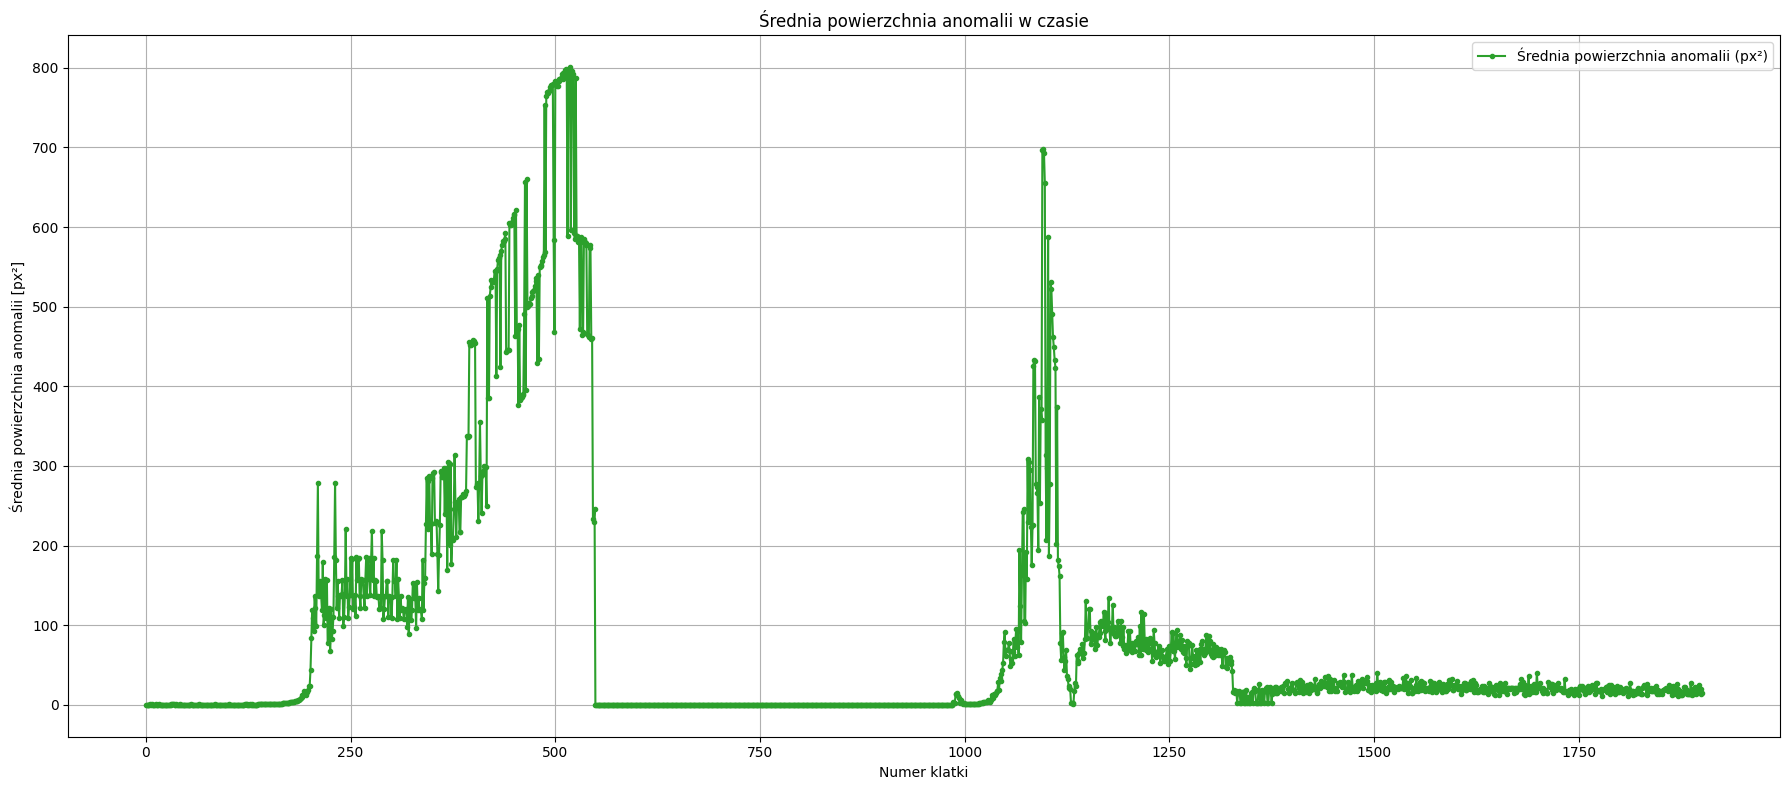

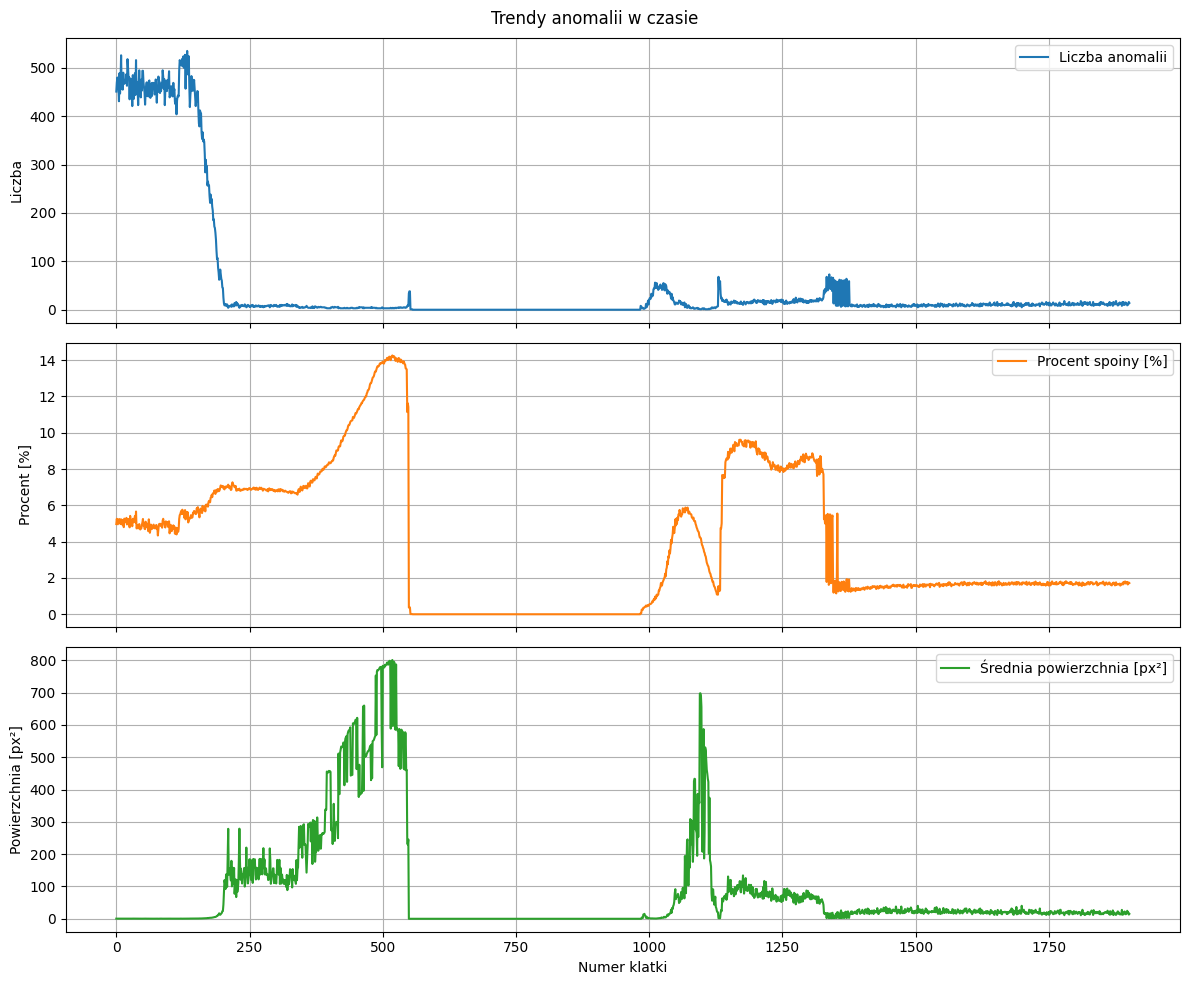

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# === Ścieżka do CSV ===
csv_path = f'anomaly_metrics_{seq_file_name}.csv'

# === Wczytaj dane
df = pd.read_csv(csv_path)

# === Ekstrahuj numer klatki z nazwy pliku
df['frame_num'] = df['frame'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

# === Sortuj po numerze klatki
df = df.sort_values('frame_num')

# === Konwertuj na float (jeśli nie są)
df['mean_anomaly_area'] = df['mean_anomaly_area'].astype(float)

# === Wykres
plt.figure(figsize=(18, 8))
plt.plot(df['frame_num'], df['mean_anomaly_area'], color='tab:green', label='Średnia powierzchnia anomalii (px²)', marker='.')

plt.xlabel("Numer klatki")
plt.ylabel("Średnia powierzchnia anomalii [px²]")
plt.title("Średnia powierzchnia anomalii w czasie")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Liczba anomalii
axs[0].plot(df['frame_num'], df['num_anomalies'], label='Liczba anomalii', color='tab:blue')
axs[0].set_ylabel("Liczba")
axs[0].legend()
axs[0].grid(True)

# Procent powierzchni
axs[1].plot(df['frame_num'], df['anomaly_ratio_percent'], label='Procent spoiny [%]', color='tab:orange')
axs[1].set_ylabel("Procent [%]")
axs[1].legend()
axs[1].grid(True)

# Średnia powierzchnia
axs[2].plot(df['frame_num'], df['mean_anomaly_area'], label='Średnia powierzchnia [px²]', color='tab:green')
axs[2].set_xlabel("Numer klatki")
axs[2].set_ylabel("Powierzchnia [px²]")
axs[2].legend()
axs[2].grid(True)

plt.suptitle("Trendy anomalii w czasie")
plt.tight_layout()
plt.show()



In [15]:
import cv2
import numpy as np
import csv
import os
import glob

# === KONFIGURACJA ===
seq_file_name = '600_51n12_1_2mm_-161_09_02_18_483'
frames_dir = f'frames_output/{seq_file_name}/preview_fixed'
mask_path = 'images/maska.png'
output_csv = f'anomaly_metrics_with_geometry_{seq_file_name}.csv'

# === Wczytaj maskę spoiny ===
spoiny_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if spoiny_mask is None:
    raise ValueError("Nie można wczytać maski spoiny!")

# === Lista klatek ===
frame_files = sorted(glob.glob(os.path.join(frames_dir, 'frame_*.jpg')))
print(f"Znaleziono {len(frame_files)} klatek do przetworzenia.")

# === Przygotowanie pliku CSV ===
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "frame",
        "num_temp_anomalies",
        "temp_anomaly_ratio_percent",
        "mean_temp_anomaly_area",
        "num_geom_objects",
        "geom_edge_area"
    ])

    for frame_path in frame_files:
        frame_name = os.path.basename(frame_path)
        thermal_img = cv2.imread(frame_path, cv2.IMREAD_UNCHANGED)
        if thermal_img is None:
            print(f"❌ Nie można wczytać: {frame_name}")
            continue

        if len(thermal_img.shape) == 3:
            thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)
        thermal_img = thermal_img.astype(np.float32)

        # Dopasowanie maski
        if spoiny_mask.shape != thermal_img.shape:
            spoiny_mask_resized = cv2.resize(spoiny_mask, (thermal_img.shape[1], thermal_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        else:
            spoiny_mask_resized = spoiny_mask.copy()

        _, spoiny_mask_bin = cv2.threshold(spoiny_mask_resized, 127, 1, cv2.THRESH_BINARY)

        spoiny_temps = thermal_img[spoiny_mask_bin == 1]
        if len(spoiny_temps) == 0:
            print(f"⚠️ Pusta maska w {frame_name}")
            continue

        # === TERMICZNA DETEKCJA ===
        mean_temp = np.mean(spoiny_temps)
        std_temp = np.std(spoiny_temps)

        anomaly_mask = np.zeros_like(spoiny_mask_resized, dtype=np.uint8)
        anomaly_pixels = (thermal_img > mean_temp + 2 * std_temp) | (thermal_img < mean_temp - 2 * std_temp)
        anomaly_mask[(spoiny_mask_bin == 1) & anomaly_pixels] = 255

        contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_temp_anomalies = len(contours)
        temp_anomaly_ratio = (np.sum(anomaly_mask == 255) / np.sum(spoiny_mask_bin == 1)) * 100
        areas = [cv2.contourArea(cnt) for cnt in contours]
        mean_temp_anomaly_area = np.sum(areas) / num_temp_anomalies if num_temp_anomalies > 0 else 0.0

        # === GEOMETRYCZNA DETEKCJA (CANNY) ===
        thermal_uint8 = thermal_img.astype(np.uint8)
        edges = cv2.Canny(thermal_uint8, 50, 150)
        edges_in_spoiny = cv2.bitwise_and(edges, edges, mask=spoiny_mask_bin.astype(np.uint8))

        # Znajdź kontury krawędzi
        geom_contours, _ = cv2.findContours(edges_in_spoiny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_geom_objects = len(geom_contours)
        geom_edge_area = np.sum([cv2.contourArea(cnt) for cnt in geom_contours])

        # === Zapis do CSV ===
        writer.writerow([
            frame_name,
            num_temp_anomalies,
            f"{temp_anomaly_ratio:.2f}",
            f"{mean_temp_anomaly_area:.2f}",
            num_geom_objects,
            f"{geom_edge_area:.2f}"
        ])

        print(f"✅ {frame_name} | TERM: {num_temp_anomalies} ({temp_anomaly_ratio:.2f}%) | GEOM: {num_geom_objects}, {geom_edge_area:.2f} px²")

print(f"\n📦 Dane zapisane do: {output_csv}")


Znaleziono 2401 klatek do przetworzenia.
✅ frame_000000.jpg | TERM: 457 (3.73%) | GEOM: 516, 2220.00 px²
✅ frame_000001.jpg | TERM: 468 (3.90%) | GEOM: 533, 2065.00 px²
✅ frame_000002.jpg | TERM: 447 (3.68%) | GEOM: 535, 1897.00 px²
✅ frame_000003.jpg | TERM: 464 (3.90%) | GEOM: 480, 2134.00 px²
✅ frame_000004.jpg | TERM: 469 (3.90%) | GEOM: 448, 2463.00 px²
✅ frame_000005.jpg | TERM: 470 (3.85%) | GEOM: 470, 2172.50 px²
✅ frame_000006.jpg | TERM: 437 (3.65%) | GEOM: 514, 1979.50 px²
✅ frame_000007.jpg | TERM: 491 (3.92%) | GEOM: 501, 2192.50 px²
✅ frame_000008.jpg | TERM: 502 (4.13%) | GEOM: 525, 2122.00 px²
✅ frame_000009.jpg | TERM: 419 (3.48%) | GEOM: 481, 2267.00 px²
✅ frame_000010.jpg | TERM: 483 (4.01%) | GEOM: 499, 2141.50 px²
✅ frame_000011.jpg | TERM: 490 (4.24%) | GEOM: 513, 2143.50 px²
✅ frame_000012.jpg | TERM: 482 (4.10%) | GEOM: 505, 2013.50 px²
✅ frame_000013.jpg | TERM: 470 (4.02%) | GEOM: 494, 2156.50 px²
✅ frame_000014.jpg | TERM: 477 (3.81%) | GEOM: 491, 2255.50 px²

In [16]:
import cv2
import numpy as np
import csv
import os
import glob

# === KONFIGURACJA ===
seq_file_name = '600_51n12_1_2mm_-161_09_02_18_483'
frames_dir = f'frames_output/{seq_file_name}/preview_fixed'
mask_path = 'images/maska.png'
output_csv = f'anomaly_metrics_with_quality_{seq_file_name}.csv'

# === PROGI KLASYFIKACJI ===
geom_thresh_contours = 10
geom_thresh_area = 200
term_thresh_percent = 2.0
term_thresh_area = 30

# === Wczytaj maskę spoiny ===
spoiny_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if spoiny_mask is None:
    raise ValueError("❌ Nie można wczytać maski spoiny!")

# === Lista klatek ===
frame_files = sorted(glob.glob(os.path.join(frames_dir, 'frame_*.jpg')))
print(f"🔍 Znaleziono {len(frame_files)} klatek do przetworzenia.")

# === Przygotowanie pliku CSV ===
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "frame",
        "num_temp_anomalies",
        "temp_anomaly_ratio_percent",
        "mean_temp_anomaly_area",
        "num_geom_objects",
        "geom_edge_area",
        "quality_class"
    ])

    for frame_path in frame_files:
        frame_name = os.path.basename(frame_path)
        thermal_img = cv2.imread(frame_path, cv2.IMREAD_UNCHANGED)
        if thermal_img is None:
            print(f"⚠️ Nie można wczytać: {frame_name}")
            continue

        # Konwersja do szarości i float32
        if len(thermal_img.shape) == 3:
            thermal_img = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2GRAY)
        thermal_img = thermal_img.astype(np.float32)

        # Dopasowanie maski
        if spoiny_mask.shape != thermal_img.shape:
            spoiny_mask_resized = cv2.resize(spoiny_mask, (thermal_img.shape[1], thermal_img.shape[0]), interpolation=cv2.INTER_NEAREST)
        else:
            spoiny_mask_resized = spoiny_mask.copy()

        _, spoiny_mask_bin = cv2.threshold(spoiny_mask_resized, 127, 1, cv2.THRESH_BINARY)

        spoiny_temps = thermal_img[spoiny_mask_bin == 1]
        if len(spoiny_temps) == 0:
            print(f"⚠️ Pusta maska w {frame_name}")
            continue

        # === DETEKCJA TERMICZNA ===
        mean_temp = np.mean(spoiny_temps)
        std_temp = np.std(spoiny_temps)

        anomaly_mask = np.zeros_like(spoiny_mask_resized, dtype=np.uint8)
        anomaly_pixels = (thermal_img > mean_temp + 2 * std_temp) | (thermal_img < mean_temp - 2 * std_temp)
        anomaly_mask[(spoiny_mask_bin == 1) & anomaly_pixels] = 255

        contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_temp_anomalies = len(contours)
        temp_anomaly_ratio = (np.sum(anomaly_mask == 255) / np.sum(spoiny_mask_bin == 1)) * 100
        areas = [cv2.contourArea(cnt) for cnt in contours]
        mean_temp_anomaly_area = np.sum(areas) / num_temp_anomalies if num_temp_anomalies > 0 else 0.0

        # === DETEKCJA GEOMETRYCZNA (CANNY) ===
        thermal_uint8 = thermal_img.astype(np.uint8)
        edges = cv2.Canny(thermal_uint8, 50, 150)
        edges_in_spoiny = cv2.bitwise_and(edges, edges, mask=spoiny_mask_bin.astype(np.uint8))
        geom_contours, _ = cv2.findContours(edges_in_spoiny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_geom_objects = len(geom_contours)
        geom_edge_area = np.sum([cv2.contourArea(cnt) for cnt in geom_contours])

        # === KLASYFIKACJA JAKOŚCI ===
        is_geom_bad = (num_geom_objects > geom_thresh_contours) or (geom_edge_area > geom_thresh_area)
        is_term_bad = (temp_anomaly_ratio > term_thresh_percent) or (mean_temp_anomaly_area > term_thresh_area)

        if is_term_bad and is_geom_bad:
            quality_class = "MIESZANA"
        elif is_term_bad:
            quality_class = "TERM_WADA"
        elif is_geom_bad:
            quality_class = "GEOM_WADA"
        else:
            quality_class = "OK"

        # === Zapis do CSV ===
        writer.writerow([
            frame_name,
            num_temp_anomalies,
            f"{temp_anomaly_ratio:.2f}",
            f"{mean_temp_anomaly_area:.2f}",
            num_geom_objects,
            f"{geom_edge_area:.2f}",
            quality_class
        ])

        print(f"✅ {frame_name} | TERM: {num_temp_anomalies} ({temp_anomaly_ratio:.2f}%, śr. {mean_temp_anomaly_area:.2f}) | GEOM: {num_geom_objects}, {geom_edge_area:.2f} px² | → {quality_class}")

print(f"\n📦 Wszystkie dane zapisane do: {output_csv}")


🔍 Znaleziono 2401 klatek do przetworzenia.
✅ frame_000000.jpg | TERM: 457 (3.73%, śr. 0.10) | GEOM: 516, 2220.00 px² | → MIESZANA
✅ frame_000001.jpg | TERM: 468 (3.90%, śr. 0.10) | GEOM: 533, 2065.00 px² | → MIESZANA
✅ frame_000002.jpg | TERM: 447 (3.68%, śr. 0.10) | GEOM: 535, 1897.00 px² | → MIESZANA
✅ frame_000003.jpg | TERM: 464 (3.90%, śr. 0.11) | GEOM: 480, 2134.00 px² | → MIESZANA
✅ frame_000004.jpg | TERM: 469 (3.90%, śr. 0.10) | GEOM: 448, 2463.00 px² | → MIESZANA
✅ frame_000005.jpg | TERM: 470 (3.85%, śr. 0.09) | GEOM: 470, 2172.50 px² | → MIESZANA
✅ frame_000006.jpg | TERM: 437 (3.65%, śr. 0.10) | GEOM: 514, 1979.50 px² | → MIESZANA
✅ frame_000007.jpg | TERM: 491 (3.92%, śr. 0.09) | GEOM: 501, 2192.50 px² | → MIESZANA
✅ frame_000008.jpg | TERM: 502 (4.13%, śr. 0.09) | GEOM: 525, 2122.00 px² | → MIESZANA
✅ frame_000009.jpg | TERM: 419 (3.48%, śr. 0.11) | GEOM: 481, 2267.00 px² | → MIESZANA
✅ frame_000010.jpg | TERM: 483 (4.01%, śr. 0.10) | GEOM: 499, 2141.50 px² | → MIESZANA


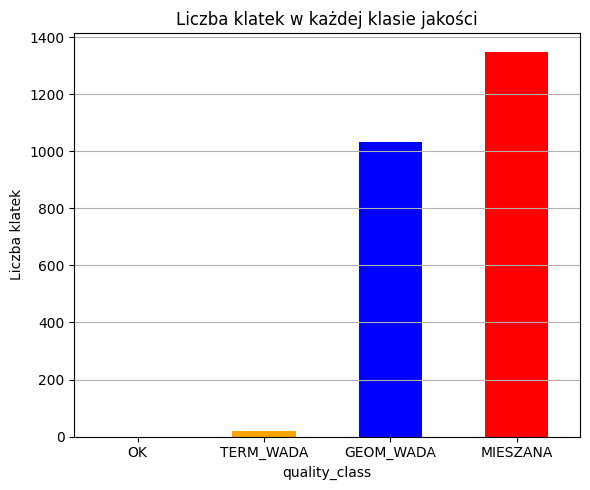

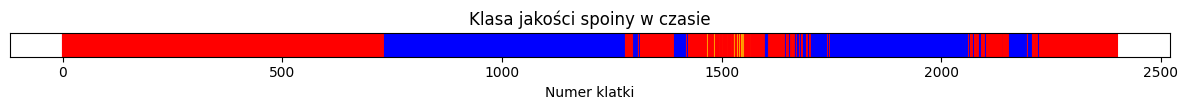

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# === Wczytaj dane z CSV
csv_path = f'anomaly_metrics_with_quality_{seq_file_name}.csv'
df = pd.read_csv(csv_path)

# === Wyodrębnij numer klatki
df['frame_num'] = df['frame'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df = df.sort_values('frame_num')

# === Wykres słupkowy: liczba klatek w każdej klasie
plt.figure(figsize=(6, 5))
df['quality_class'].value_counts().reindex(['OK', 'TERM_WADA', 'GEOM_WADA', 'MIESZANA']).plot(kind='bar', color=['green', 'orange', 'blue', 'red'])
plt.title("Liczba klatek w każdej klasie jakości")
plt.ylabel("Liczba klatek")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Mapuj klasy na kolory
color_map = {
    "OK": "green",
    "TERM_WADA": "orange",
    "GEOM_WADA": "blue",
    "MIESZANA": "red"
}
colors = df['quality_class'].map(color_map)

# Rysuj jako pasek
plt.figure(figsize=(12, 1.2))
plt.scatter(df['frame_num'], [1]*len(df), c=colors, marker='|', s=500)
plt.title("Klasa jakości spoiny w czasie")
plt.yticks([])
plt.xlabel("Numer klatki")
plt.tight_layout()
plt.show()

